# Goal
In this session,
- We will see the basics of face detection using Haar Feature-based Cascade Classifiers
- We will extend the same for eye detection etc.

# Basics

Object Detection using Haar feature-based cascade classifiers is an effective object detection method proposed by Paul Viola and Michael Jones in their paper, "Rapid Object Detection using a Boosted Cascade of Simple Features" in 2001. It is a machine learning based approach where a cascade function is trained from a lot of positive and negative images. It is then used to detect objects in other images.

Here we will work with face detection. Initially, the algorithm needs a lot of positive images (images of faces) and negative images (images without faces) to train the classifier. Then we need to extract features from it. For this, haar features shown in below image are used. They are just like our convolutional kernel. Each feature is a single value obtained by subtracting sum of pixels under white rectangle from sum of pixels under black rectangle.

<figure>
    <img src="images/haar_features.jpg" >
    <figcaption style="text-align: center; font-weight: bold">Figure 1. Haar features</figcaption>
</figure>

Now all possible sizes and locations of each kernel is used to calculate plenty of features. (Just imagine how much computation it needs? Even a 24x24 window results over 160000 features). For each feature calculation, we need to find sum of pixels under white and black rectangles. To solve this, they introduced the integral images. It simplifies calculation of sum of pixels, how large may be the number of pixels, to an operation involving just four pixels. Nice, isn't it? It makes things super-fast.

But among all these features we calculated, most of them are irrelevant. For example, consider the image below. Top row shows two good features. The first feature selected seems to focus on the property that the region of the eyes is often darker than the region of the nose and cheeks. The second feature selected relies on the property that the eyes are darker than the bridge of the nose. But the same windows applying on cheeks or any other place is irrelevant. So how do we select the best features out of 160000+ features? It is achieved by **Adaboost**.

<figure>
    <img src="images/haar_features.jpg" >
    <figcaption style="text-align: center; font-weight: bold">Figure 2. Apply Haar features</figcaption>
</figure>

For this, we apply each and every feature on all the training images. For each feature, it finds the best threshold which will classify the faces to positive and negative. But obviously, there will be errors or misclassifications. We select the features with minimum error rate, which means they are the features that best classifies the face and non-face images. (The process is not as simple as this. Each image is given an equal weight in the beginning. After each classification, weights of misclassified images are increased. Then again same process is done. New error rates are calculated. Also new weights. The process is continued until required accuracy or error rate is achieved or required number of features are found).

Final classifier is a weighted sum of these weak classifiers. It is called weak because it alone can't classify the image, but together with others forms a strong classifier. The paper says even 200 features provide detection with 95% accuracy. Their final setup had around 6000 features. (Imagine a reduction from 160000+ features to 6000 features. That is a big gain).

So now you take an image. Take each 24x24 window. Apply 6000 features to it. Check if it is face or not. Wow.. Wow.. Isn't it a little inefficient and time consuming? Yes, it is. Authors have a good solution for that.

In an image, most of the image region is non-face region. So it is a better idea to have a simple method to check if a window is not a face region. If it is not, discard it in a single shot. Don't process it again. Instead focus on region where there can be a face. This way, we can find more time to check a possible face region.

For this they introduced the concept of **Cascade of Classifiers**. Instead of applying all the 6000 features on a window, group the features into different stages of classifiers and apply one-by-one. (Normally first few stages will contain very less number of features). If a window fails the first stage, discard it. We don't consider remaining features on it. If it passes, apply the second stage of features and continue the process. The window which passes all stages is a face region. How is the plan !!!

Authors' detector had 6000+ features with 38 stages with 1, 10, 25, 25 and 50 features in first five stages. (Two features in the above image is actually obtained as the best two features from Adaboost). According to authors, on an average, 10 features out of 6000+ are evaluated per sub-window.

So this is a simple intuitive explanation of how Viola-Jones face detection works. Read paper for more details or check out the references in Additional Resources section.

# Haar-cascade Detection in OpenCV

OpenCV comes with a trainer as well as detector. If you want to train your own classifier for any object like car, planes etc. you can use OpenCV to create one. Its full details are given here: [**Cascade Classifier Training**](http://docs.opencv.org/trunk/dc/d88/tutorial_traincascade.html).

Here we will deal with detection. OpenCV already contains many pre-trained classifiers for face, eyes, smile etc. Those XML files are stored in opencv/data/haarcascades/ folder. Let's create face and eye detector with OpenCV.

In [29]:
# Run some setup code for this notebook.
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

First we need to load the required XML classifiers. Then load our input image (or video) in grayscale mode.

In [30]:
face_cascade = cv2.CascadeClassifier("data/haarcascades/haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier("data/haarcascades/haarcascade_eye.xml")

img = mpimg.imread("images/GoT.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

Now we find the faces in the image. If faces are found, it returns the positions of detected faces as Rect(x,y,w,h). Once we get these locations, we can create a ROI for the face and apply eye detection on this ROI (since eyes are always on the face !!! ).

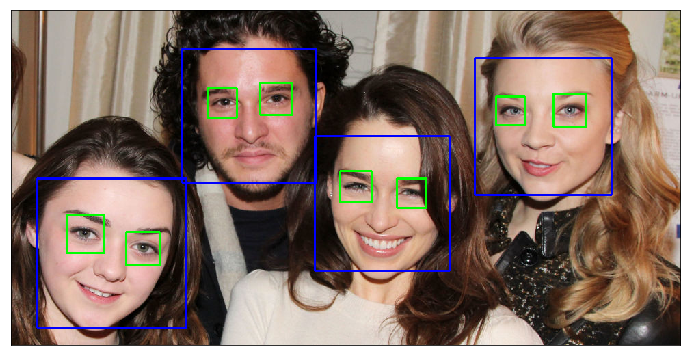

In [31]:
BLUE = (0, 0, 255)
GREEN = (0, 255, 0)
LINE_WIDTH = 2

# detect faces using cascade classifier
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=4)

# draw face regions
for (x, y, w, h) in faces:
    face_top_left = (x, y)
    face_right_bottom = (x + w, y + h)
    cv2.rectangle(img, face_top_left, face_right_bottom, BLUE, LINE_WIDTH)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]

    # detect eyes
    eyes = eye_cascade.detectMultiScale(roi_gray, scaleFactor=1.2, minNeighbors=4)

    # draw eye regions
    for (ex, ey, ew, eh) in eyes:
        eye_top_left = (ex, ey)
        eye_right_bottom = (ex + ew, ey + eh)
        cv2.rectangle(roi_color, eye_top_left, eye_right_bottom, GREEN, LINE_WIDTH)

plt.imshow(img)
plt.xticks(())
plt.yticks(())
plt.show()

# Additional Resources

1. Video Lecture on [Face Detection and Tracking](https://www.youtube.com/watch?v=WfdYYNamHZ8)
2. An interesting interview regarding Face Detection by [Adam Harvey](http://www.makematics.com/research/viola-jones/)